In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import matplotlib.pyplot as plt
import numpy as np

2025-09-29 16:00:38.973347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759161639.362860      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759161639.470210      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


x_train shape: (50000, 32, 32, 3), y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3), y_test shape: (10000, 1)


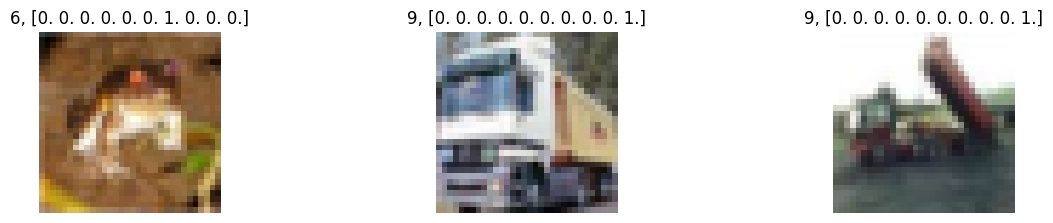

In [9]:
# -------------------------
# 1. Load CIFAR-10 dataset
# -------------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
x_train_small = x_train[:5000]
y_train_small = y_train[:5000]
x_test_small = x_test[:1000]
y_test_small = y_test[:1000]
x_train = x_train_small
y_train = y_train_small
y_test = y_test_small
x_test = x_test_small
train_images=x_train
train_labels=y_train.flatten()
plt.figure(figsize=(20, 20))
plot_index = 1
num_images = 3  # Number of images to plot

for i in range(num_images):
    plt.subplot(10, 10, plot_index)  # Adjust grid to fit images
    plt.imshow(train_images[i], cmap="gray")
    plt.title(f"{train_labels[i]}, {tf.one_hot(train_labels[i], 10)}")
    plt.axis("off")
    plot_index += 2

plt.tight_layout()
plt.show()

NUM_CLASSES = 10
IMG_SIZE = (224, 224)   # ResNet50 expects 224x224
BATCH_SIZE = 64

# one-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

In [10]:
# -------------------------
# 2. Preprocess: resize and normalize using tf.data
# -------------------------
def preprocess(images, labels):
    images = tf.image.resize(images, IMG_SIZE)
    images = preprocess_input(images)  # VGG16 preprocessing
    return images, labels

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(50000).batch(BATCH_SIZE).map(preprocess).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).map(preprocess).prefetch(tf.data.AUTOTUNE)


In [27]:
# -------------------------
# 3. Build model: ResNet50 base + custom head
# -------------------------
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False   # Phase A: freeze all

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [33]:
1e-2

0.01

In [28]:
# -------------------------
# 4. Compile and train head
# -------------------------
model.compile(optimizer=optimizers.Adamax(1e-3),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history_head = model.fit(train_ds, validation_data=val_ds, epochs=20, batch_size=BATCH_SIZE)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 299ms/step - accuracy: 0.3829 - loss: 2.1073 - val_accuracy: 0.7930 - val_loss: 0.6178
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 189ms/step - accuracy: 0.7042 - loss: 0.8353 - val_accuracy: 0.8260 - val_loss: 0.5116
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 195ms/step - accuracy: 0.7598 - loss: 0.6804 - val_accuracy: 0.8500 - val_loss: 0.4566
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 197ms/step - accuracy: 0.7870 - loss: 0.6160 - val_accuracy: 0.8640 - val_loss: 0.4252
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 203ms/step - accuracy: 0.8079 - loss: 0.5596 - val_accuracy: 0.8770 - val_loss: 0.4030
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.8124 - loss: 0.5150 - val_accuracy: 0.8710 - val_loss: 0.4035
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 209ms/step - accuracy: 0.8391 - loss: 0.4739 - val_accuracy: 0.8700 - val_loss: 0.3927
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 210ms/step - accuracy: 0.8203 - loss: 0.4877 - val_accu

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


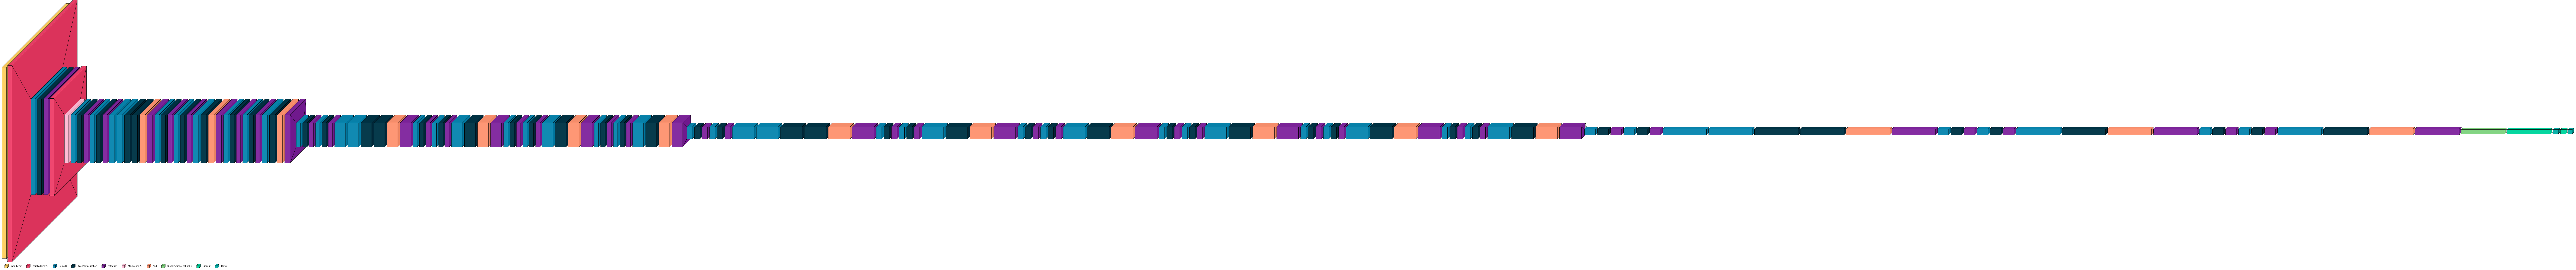

"dot" with args ['-Tpng', '/tmp/tmpqf8rpd6v/tmpudp1s4ca'] returned code: -6

stdout, stderr:
 b''
b"failed at node 10590[1]\ndot: maze.c:313: chkSgraph: Assertion `np->cells[1]' failed.\n"

plot_model error (needs graphviz/pydot): "dot" with args ['-Tpng', '/tmp/tmpqf8rpd6v/tmpudp1s4ca'] returned code: -6


In [35]:
# Visualize the model architecture with visualkeras and tf.keras.utils.plot_model
try:
    import visualkeras
except Exception:
    # in a Jupyter notebook use %pip; fallback uses sys.executable for script contexts
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "visualkeras", "graphviz", "pydot"])
    import visualkeras
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display
import os

# 1) visualkeras layered view (PIL image saved)
try:
    visualkeras.layered_view(model, legend=True, to_file="model_visual.png")
    if os.path.exists("model_visual.png"):
        display(Image("model_visual.png"))
except Exception as e:
    print("visualkeras error:", e)

# 2) Keras plot_model (requires graphviz + pydot)
try:
    plot_model(model, to_file="model_graph.png", show_shapes=True, show_layer_names=True)
    if os.path.exists("model_graph.png"):
        display(Image("model_graph.png"))
except Exception as e:
    print("plot_model error (needs graphviz/pydot):", e)


In [29]:
model.evaluate(val_ds)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.8805 - loss: 0.3640


[0.34855175018310547, 0.8799999952316284]

In [17]:
# CIFAR-10 class names
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

def plot_cifar_predictions(model, x_test, y_test, num_images=5, img_size=(224, 224)):
    """
    Plot CIFAR-10 test images with predicted and true labels (with one-hot).
    
    Args:
        model: Trained Keras model.
        x_test: Test images (numpy array, shape (N, 32, 32, 3)).
        y_test: One-hot encoded test labels (numpy array, shape (N, 10)).
        num_images: Number of test samples to visualize.
        img_size: Target size for ResNet50 preprocessing.
    """
    plt.figure(figsize=(12, 12))
    plot_index = 1

    for i in range(num_images):
        # Extract one image and its label
        sample = x_test[i:i+1]   # (1, 32, 32, 3)
        true = y_test[i]         # one-hot vector

        # Resize + preprocess for ResNet50
        sample_resized = tf.image.resize(sample, img_size)      # (1, 224, 224, 3)
        sample_resized = preprocess_input(sample_resized)       # ResNet50 preprocessing

        # Predict
        pred = model.predict(sample_resized, verbose=0)
        predicted_label = np.argmax(pred)
        true_label = np.argmax(true)

        # Show original CIFAR-10 image (not resized)
        plt.subplot(3, 3, plot_index)
        plt.imshow(x_test[i])

        # Pick color: green if correct, red if wrong
        color = "green" if predicted_label == true_label else "red"
        
        plt.title(
            f"Pred: {predicted_label} ({class_names[predicted_label]})\n{pred[0].round(2)}\n"
            f"True: {true_label} ({class_names[true_label]})\n{true}",
            color=color,
            fontsize=8
        )
        plt.axis("off")
        plot_index += 1

    plt.tight_layout()
    plt.show()

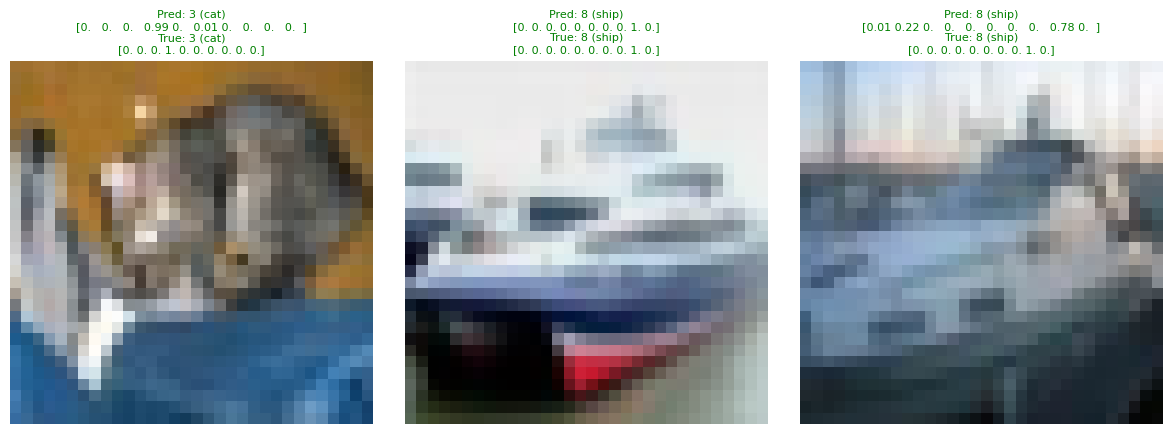

In [30]:
plot_cifar_predictions(model, x_test, y_test, num_images=3, img_size=IMG_SIZE)


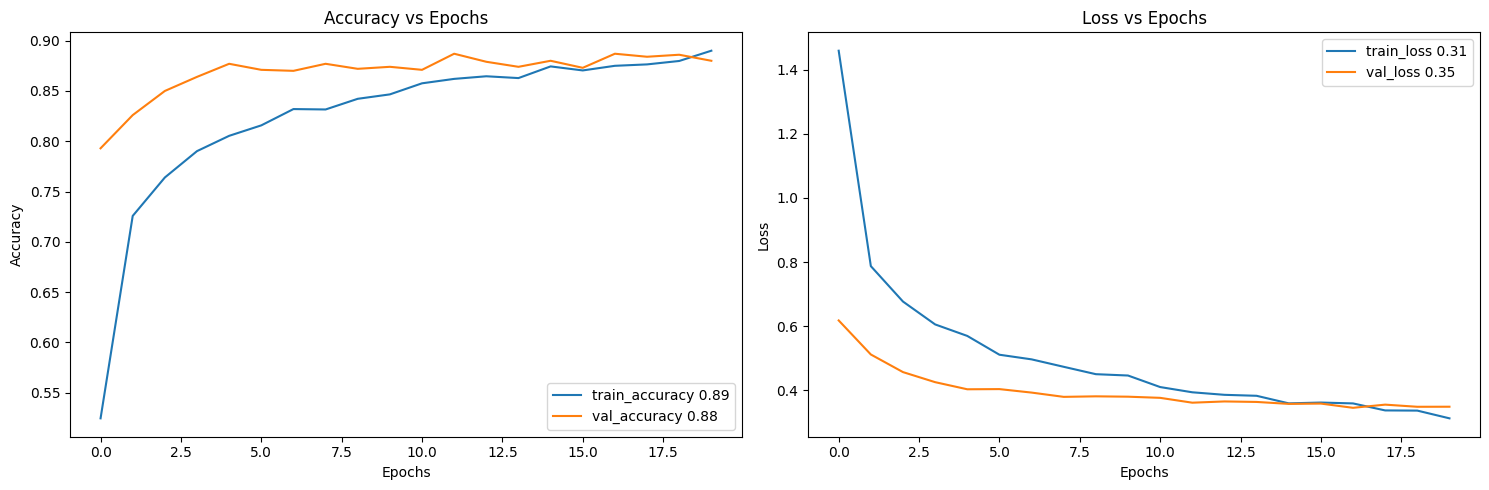

In [31]:
def sub_plot_graph(history, title1, title2):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label=f"train_accuracy {history.history['accuracy'][-1]:.2f}")
    plt.plot(history.history['val_accuracy'], label=f"val_accuracy {history.history['val_accuracy'][-1]:.2f}")
    plt.title(title1)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label=f"train_loss {history.history['loss'][-1]:.2f}")
    plt.plot(history.history['val_loss'], label=f"val_loss {history.history['val_loss'][-1]:.2f}")
    plt.title(title2)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

sub_plot_graph(history_head, "Accuracy vs Epochs", "Loss vs Epochs")

In [39]:
len(model.layers)

180

In [40]:
len(base_model.layers)

175

In [41]:
def unfreeze_slice(index):
    for i, layer in enumerate(base_model.layers[index:]):
        layer.trainable = True
        print(f"Unfrozen: {layer.name} (index {index + i})")

In [ ]:
histories = {}

# Loop over different numbers of layers to unfreeze
for num_layers_to_unfreeze in range(1, len(base_model.layers)+1,5):  # unfreeze last layers
    print(f"\n=== Unfreezing last {num_layers_to_unfreeze} layers ===")

    # Freeze everything again to reset
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze last `num_layers_to_unfreeze` layers
    for i, layer in enumerate(base_model.layers[-num_layers_to_unfreeze:]):
        layer.trainable = True
        print(f"Unfrozen: {layer.name} (index {len(base_model.layers)-num_layers_to_unfreeze+i})")

    # Recompile after changing trainability
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        batch_size=BATCH_SIZE,
        verbose=0
    )

    # Store history
    histories[f"unfreeze_{num_layers_to_unfreeze}"] = history

    # Evaluate
    results = model.evaluate(val_ds, verbose=0)
    print(f"Validation loss: {results[0]:.4f}, Validation accuracy: {results[1]:.4f}")

    # Plot curves for this experiment
    sub_plot_graph(
        history,
        f"Accuracy vs Epochs (unfreeze {num_layers_to_unfreeze})",
        f"Loss vs Epochs (unfreeze {num_layers_to_unfreeze})"
    )
    plot_cifar_predictions(model, x_test, y_test, num_images=3, img_size=IMG_SIZE)


=== Unfreezing last 1 layers ===
Unfrozen: conv5_block3_out (index 174)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Collect results from histories
unfreeze_counts = []
final_val_acc = []
final_acc = []
final_val_loss = []
final_loss = []

for key, history in histories.items():
    unfreeze_num = int(key.split("_")[1])  
    acc = history.history["val_accuracy"][-1]
    loss = history.history["val_loss"][-1]
    accf = history.history["accuracy"][-1]
    lossf = history.history["loss"][-1]
    unfreeze_counts.append(unfreeze_num)
    final_val_acc.append(acc)
    final_val_loss.append(loss)
    final_acc.append(accf)
    final_loss.append(lossf)

# Sort results by number of unfrozen layers
order = np.argsort(unfreeze_counts)
unfreeze_counts = np.array(unfreeze_counts)[order]
final_val_acc = np.array(final_val_acc)[order]
final_val_loss = np.array(final_val_loss)[order]
final_acc = np.array(final_acc)[order]
final_loss = np.array(final_loss)[order]

# --- 1. Side-by-side Bar Charts (Accuracy & Loss) ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].bar(unfreeze_counts, final_acc, color="blue")
axes[0].bar(unfreeze_counts, final_val_acc, color="skyblue")
axes[0].set_xlabel("Unfrozen Layers")
axes[0].set_ylabel("Validation Accuracy")
axes[0].set_title("Effect of Unfreezing on Accuracy")
axes[0].set_xticks(unfreeze_counts)
axes[1].bar(unfreeze_counts, final_loss, color="orange")
axes[1].bar(unfreeze_counts, final_val_loss, color="salmon")
axes[1].set_xlabel("Unfrozen Layers")
axes[1].set_ylabel("Validation Loss")
axes[1].set_title("Effect of Unfreezing on Loss")
axes[1].set_xticks(unfreeze_counts)

plt.tight_layout()
plt.show()

#####
x = np.arange(len(unfreeze_counts))  # positions for bars
width = 0.35  # width of each bar

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Accuracy ---
axes[0].bar(x - width/2, final_acc, width, label="Train Acc", color="blue")
axes[0].bar(x + width/2, final_val_acc, width, label="Val Acc", color="skyblue")
axes[0].set_xlabel("Unfrozen Layers")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Effect of Unfreezing on Accuracy")
axes[0].set_xticks(x)
axes[0].set_xticklabels(unfreeze_counts)
axes[0].legend()

# --- Loss ---
axes[1].bar(x - width/2, final_loss, width, label="Train Loss", color="orange")
axes[1].bar(x + width/2, final_val_loss, width, label="Val Loss", color="salmon")
axes[1].set_xlabel("Unfrozen Layers")
axes[1].set_ylabel("Loss")
axes[1].set_title("Effect of Unfreezing on Loss")
axes[1].set_xticks(x)
axes[1].set_xticklabels(unfreeze_counts)
axes[1].legend()

plt.tight_layout()
plt.show()

# --- 2. Dual-axis Line Plot (Accuracy + Loss vs Layers) ---
fig, ax1 = plt.subplots(figsize=(8,5))

color = "tab:blue"
ax1.set_xlabel("Unfrozen Layers")
ax1.set_ylabel("Validation Accuracy", color=color)
ax1.plot(unfreeze_counts, final_val_acc, marker="o", color=color, label="Val Accuracy")
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Validation Loss", color=color)
ax2.plot(unfreeze_counts, final_val_loss, marker="s", color=color, label="Val Loss")
ax2.tick_params(axis="y", labelcolor=color)

plt.title("Effect of Unfreezing Layers on Accuracy & Loss")
fig.tight_layout()
plt.show()
################
fig, ax1 = plt.subplots(figsize=(8,5))

color = "tab:blue"
ax1.set_xlabel("Unfrozen Layers")
ax1.set_ylabel("Accuracy", color=color)
ax1.plot(unfreeze_counts, final_acc, marker="o", color=color, label="Accuracy")
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Loss", color=color)
ax2.plot(unfreeze_counts, final_loss, marker="s", color=color, label="Loss")
ax2.tick_params(axis="y", labelcolor=color)

plt.title("Effect of Unfreezing Layers on Accuracy & Loss")
fig.tight_layout()
plt.show()
#####
# --- Dual-axis Line Plot with Training + Validation ---
fig, ax1 = plt.subplots(figsize=(8,5))

color = "tab:blue"
ax1.set_xlabel("Unfrozen Layers")
ax1.set_ylabel("Accuracy", color=color)
ax1.plot(unfreeze_counts, final_acc, marker="o", linestyle="--", color=color, label="Train Accuracy")
ax1.plot(unfreeze_counts, final_val_acc, marker="s", linestyle="-", color=color, label="Val Accuracy")
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()
color = "tab:red"
ax2.set_ylabel("Loss", color=color)
ax2.plot(unfreeze_counts, final_loss, marker="^", linestyle="--", color=color, label="Train Loss")
ax2.plot(unfreeze_counts, final_val_loss, marker="d", linestyle="-", color=color, label="Val Loss")
ax2.tick_params(axis="y", labelcolor=color)

plt.title("Effect of Unfreezing Layers on Accuracy & Loss")

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc="center right")

fig.tight_layout()
plt.show()

# --- 3. Scatter Plot (Accuracy vs Loss Trade-off) ---

# --- Scatter: Validation ---
plt.figure(figsize=(7,6))
plt.scatter(final_val_loss, final_val_acc, c=unfreeze_counts, cmap="viridis", s=100, marker="o")
for i, txt in enumerate(unfreeze_counts):
    plt.annotate(txt, (final_val_loss[i], final_val_acc[i]), textcoords="offset points", xytext=(5,5))
plt.xlabel("Validation Loss")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Loss Across Unfreeze Steps")
plt.colorbar(label="Unfrozen Layers")
plt.show()

# --- Scatter: Training ---
plt.figure(figsize=(7,6))
plt.scatter(final_loss, final_acc, c=unfreeze_counts, cmap="plasma", s=100, marker="s")
for i, txt in enumerate(unfreeze_counts):
    plt.annotate(txt, (final_loss[i], final_acc[i]), textcoords="offset points", xytext=(5,5))
plt.xlabel("Training Loss")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy vs Loss Across Unfreeze Steps")
plt.colorbar(label="Unfrozen Layers")
plt.show()



In [ ]:


    print(f"\n=== Unfreezing layers ===")

    # Freeze everything again to reset
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze last `num_layers_to_unfreeze` layers
    for i, layer in enumerate(base_model.layers):
        layer.trainable = True
        

    # Recompile after changing trainability
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        batch_size=BATCH_SIZE,
        verbose=0
    )

    # Evaluate
    results = model.evaluate(val_ds, verbose=0)
    print(f"Validation loss: {results[0]:.4f}, Validation accuracy: {results[1]:.4f}")

    # Plot curves for this experiment
    sub_plot_graph(
        history,
        f"Accuracy vs Epochs (unfreeze {num_layers_to_unfreeze})",
        f"Loss vs Epochs (unfreeze {num_layers_to_unfreeze})"
    )
    plot_cifar_predictions(model, x_test, y_test, num_images=3, img_size=IMG_SIZE)

In [45]:
# -------------------------
# 5. Progressive unfreezing (block by block)
# -------------------------
'''def unfreeze_block(block_num):
    for layer in base_model.layers:
        if f'block{block_num}_' in layer.name:
            layer.trainable = True

blocks_to_unfreeze = [5, 4]  # you can add 3, 2, 1 for deeper fine-tuning
fine_tune_histories = []

for block in blocks_to_unfreeze:
    print(f"\n--- Unfreezing block {block} ---")
    unfreeze_block(block)
    model.compile(optimizer=optimizers.Adam(1e-5),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    hist = model.fit(train_ds, validation_data=val_ds, epochs=3)
    fine_tune_histories.append(hist)'''
    
# -------------------------
# Unfreeze a slice of layers
# -------------------------
'''def unfreeze_slice(start=None, end=None):
    """
    Unfreezes layers[start:end] (Python slicing rules).
    Example:
        unfreeze_slice(4, None)   # unfreeze from layer 4 to the end
        unfreeze_slice(None, 4)   # unfreeze first 4 layers
    """
    for i, layer in enumerate(base_model.layers[start:end]):
        layer.trainable = True
        #layer.trainable = False
        print(f"Unfrozen: {layer.name} (index {i})")

unfreeze_slice(15,None)'''

'def unfreeze_slice(start=None, end=None):\n    """\n    Unfreezes layers[start:end] (Python slicing rules).\n    Example:\n        unfreeze_slice(4, None)   # unfreeze from layer 4 to the end\n        unfreeze_slice(None, 4)   # unfreeze first 4 layers\n    """\n    for i, layer in enumerate(base_model.layers[start:end]):\n        layer.trainable = True\n        #layer.trainable = False\n        print(f"Unfrozen: {layer.name} (index {i})")\n\nunfreeze_slice(15,None)'